In [1]:
from PIL import Image
import os
import numpy as np
import tensorflow.compat.v1 as tf
import csv

In [2]:
photo = Image.open('photo.out/10002463616318_АО62399.jpg')

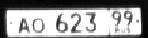

In [3]:
photo

In [4]:
photo_size = []
for n in os.listdir('photo.out/'):
    photo_size.append(Image.open('photo.out/' + n).size)

print('max =', np.array(photo_size).max(axis=0), '; min = ', np.array(photo_size).min(axis=0),
     '; average = ', np.average(np.array(photo_size), axis=0))

max = [306  90] ; min =  [58 13] ; average =  [144.31223051  38.28872554]


In [5]:
def ipg_to_numpy(path):
    image = Image.open(path)
    image.load()
    return np.asarray(image, dtype=np.int64)

In [6]:
image_shape = np.array([38, 124]).astype(np.int32)

def padding_image(image, image_shape = image_shape):
    shape = image.shape
    
    if len(shape) == 3:
        image = np.average(image, axis=2)
        shape = image.shape
        
    for i in range(image_shape[0] - shape[0]):
        image = np.vstack((image, np.zeros((1, shape[1]))))

    for i in range(image_shape[1] - shape[1]):
        image = np.hstack((image, np.zeros((image_shape[0], 1))))
        
    return image.astype(np.float32)


allowed_token = ['', 'А', 'В', 'Е', 'К', 'М', 'Н', 'О', 'Р', 'С', 'Т', 'У', 'Х'] + [str(x) for x in  range(10)]
vocab_size = len(allowed_token)

token_dict_incode = {y:x for x,y in zip(range(vocab_size), allowed_token)}
token_dict_decode = {x:y for x,y in zip(range(vocab_size), allowed_token)}

def parser_fn(image, regno, token_dict = token_dict_incode, image_shape = image_shape):

    label = []
    for tok in regno:
        label.append(token_dict[tok])
    for i in range(len(regno), 9):
        label.append(token_dict[''])
    label = np.array(label).astype(np.int32)
   
    #feature = padding_image(image)[:,:, np.newaxis]
    if len(image.shape) == 3:
        image = np.average(image, axis=2)
    feature = image[:,:, np.newaxis]
    
    return feature, (label, len(label))

def jpg_to_numpy(path):
    image = Image.open(path)
    image.load()
#    return np.asarray(image, dtype=np.float32)
    return np.asarray(image.resize((image_shape[1],image_shape[0])), dtype=np.float32)

def generator_fn(csv_path, image_path):
    
    with open(csv_path, 'r') as csv_file:
        csv_reader = csv.reader(csv_file)
        head = next(csv_reader)
        csv_head = {x: y for x,y in zip(head, range(len(head)))}
        csv_row_i = 0
        for row in csv_reader:
            csv_row_i += 1
            tr_check_id = row[csv_head['tr_check_id']]
            regno = row[csv_head['regno']]
            image = jpg_to_numpy(image_path + f'/{tr_check_id}_{regno}.jpg')
            yield parser_fn(image, regno)


def input_fn(params, mode):

    shapes = ([image_shape[0],image_shape[1],1], ([None], ()))
    types = (tf.float32, (tf.int32, tf.int32))
    defaults = (0., (0, 0))

    dataset = tf.data.Dataset.from_generator(lambda : generator_fn(params['csv_path'], params['image_path']),
                                             output_shapes=shapes,
                                             output_types=types)
    

    if mode == 'train':
#        dataset = dataset.shuffle(buffer_size=params['train_size'], reshuffle_each_iteration=True)
        dataset = dataset.repeat(params['num_epochs'])
#        dataset = dataset.repeat()

    return dataset.padded_batch(params['batch_size'], shapes, defaults).prefetch(params['train_size'])    


def test_input_fn(csv_path, image_path, params):
    '''функция подачи данных в модель для теста
        на вход получает массив строк'''
    shapes = ([image_shape[0],image_shape[1],1], ([None], ()))
    types = (tf.float32, (tf.int32, tf.int32))
    defaults = (0., (0, 0))

    dataset = tf.data.Dataset.from_generator(lambda : generator_fn(csv_path, image_path),
                                             output_shapes=shapes, output_types=types)
    
    return dataset.padded_batch(params['batch_size'], shapes, defaults).prefetch(1) 

In [140]:
a = generator_fn(params['csv_path'], params['image_path'])

In [52]:
q = next(a)[1][0]
regno = ''
for t in q:
        regno += token_dict_decode[t]
print(regno)
print(q)

К347КК197
[ 4 16 17 20  4  4 14 22 20]


In [7]:
# модель
def model_fn(features, labels, mode, params):
    conv1 = tf.layers.conv2d(
        inputs=features,
        filters=64,
        kernel_size=7,
        padding="same",
        activation=tf.nn.relu)
    
    pool1 = tf.layers.max_pooling2d(conv1, 7, 4)
    

    conv2 = tf.layers.conv2d(
        inputs=pool1,
        filters=64,
        kernel_size=5,
        padding="same",
        activation=tf.nn.relu)
    
    pool2 = tf.layers.max_pooling2d(conv2, 5, 3)

    
    reduce_max = tf.math.reduce_max(pool2, 1)

    
    dense1 = tf.layers.dense(reduce_max, params['output_vocab_size'])
#    denses = []
    
#    for _ in range(params['length_regno']):
#        dense = tf.layers.dense(dense1, params['output_vocab_size'])
#        denses += [dense]
    
#    logits = tf.stack(denses, axis=1)
    logits = dense1
    #logits = tf.math.argmax(dense1,2)
    
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        predictions = {
            'prediction': logits,
        }

        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
    else:
        target, target_lengths = labels
        print(target)

        mask = tf.sequence_mask(target_lengths, dtype=tf.float32)


        loss = tf.contrib.seq2seq.sequence_loss(logits=logits, 
                                                targets=target, 
                                                weights = mask,
                                                average_across_timesteps=True, 
                                                average_across_batch=True)

        # в режиме eval возвращаем усреднённый лосс
        if mode == tf.estimator.ModeKeys.EVAL:
            mask = tf.sequence_mask(lengths, dtype=tf.float32)
            metrics = {
                'acc': tf.metrics.accuracy(target, sample_id, mask),
                'f1_score' : tf.contrib.metrics.f1_score(tf.one_hot(target, 7), 
                                                     tf.one_hot(sample_id, 7), mask),
            }
            
            return tf.estimator.EstimatorSpec(mode, loss=loss, eval_metric_ops=metrics)

        # в режиме train ещё и обновляем обучаемые параметры
        elif mode == tf.estimator.ModeKeys.TRAIN:
            optimizer = tf.train.AdamOptimizer
            optimizer = optimizer(learning_rate=params['learning_rate'])
            train_op = optimizer.minimize(loss, global_step=tf.train.get_global_step())

            return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)
    
    


In [8]:
params = {
    'length_regno': 9,
    'output_vocab_size': vocab_size,
    'train_size': 10,
    'num_layers': 2,
    'dropout_rate': 0.2,
    'lstm_hidden_dim': 512,
    'max_iter': 10,
    'batch_size': 5,
    'num_epochs': 10,
    'learning_rate': 1e-3,
    'csv_path': 'data.csv',
    'image_path': 'photo.out'
}

config = tf.estimator.RunConfig(model_dir='pro',
                                save_checkpoints_steps = 1000,
                               save_checkpoints_secs = None)
model = tf.estimator.Estimator(model_fn=model_fn, params=params, config=config)

INFO:tensorflow:Using config: {'_model_dir': 'pro', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fa7433e5190>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [24]:
model.train(lambda: input_fn(params=params, mode='train'))

INFO:tensorflow:Calling model_fn.
Tensor("IteratorGetNext:1", shape=(?, ?), dtype=int32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into pro/model.ckpt.
INFO:tensorflow:loss = 72.75542, step = 1
INFO:tensorflow:global_step/sec: 53.4541
INFO:tensorflow:loss = 2.7129157, step = 101 (1.871 sec)
INFO:tensorflow:global_step/sec: 58.2147
INFO:tensorflow:loss = 2.6860154, step = 201 (1.718 sec)
INFO:tensorflow:global_step/sec: 57.1543
INFO:tensorflow:loss = 2.7682056, step = 301 (1.750 sec)
INFO:tensorflow:global_step/sec: 57.4112
INFO:tensorflow:loss = 2.6400275, step = 401 (1.742 sec)
INFO:tensorflow:global_step/sec: 57.9699
INFO:tensorflow:loss = 2.576481, step = 501 (1.725 sec)
INFO:tensorflow:global_step/sec: 57.5355
INFO:tensorflow:loss = 2.4487295, step = 601 (1.738 sec)
INFO:tensorflow:g

INFO:tensorflow:loss = 1.9254147, step = 7501 (1.809 sec)
INFO:tensorflow:global_step/sec: 55.9962
INFO:tensorflow:loss = 0.81839955, step = 7601 (1.786 sec)
INFO:tensorflow:global_step/sec: 55.9358
INFO:tensorflow:loss = 0.34752607, step = 7701 (1.788 sec)
INFO:tensorflow:global_step/sec: 55.4071
INFO:tensorflow:loss = 1.0120044, step = 7801 (1.805 sec)
INFO:tensorflow:global_step/sec: 55.0168
INFO:tensorflow:loss = 0.16741192, step = 7901 (1.818 sec)
INFO:tensorflow:Saving checkpoints for 8000 into pro/model.ckpt.
INFO:tensorflow:global_step/sec: 54.8281
INFO:tensorflow:loss = 0.5288395, step = 8001 (1.824 sec)
INFO:tensorflow:global_step/sec: 55.823
INFO:tensorflow:loss = 0.5721882, step = 8101 (1.791 sec)
INFO:tensorflow:global_step/sec: 55.0083
INFO:tensorflow:loss = 0.3689471, step = 8201 (1.818 sec)
INFO:tensorflow:global_step/sec: 56.1114
INFO:tensorflow:loss = 0.3799561, step = 8301 (1.782 sec)
INFO:tensorflow:global_step/sec: 56.0424
INFO:tensorflow:loss = 0.8317301, step = 8

INFO:tensorflow:loss = 0.8237899, step = 15201 (2.186 sec)
INFO:tensorflow:global_step/sec: 55.2982
INFO:tensorflow:loss = 0.4682217, step = 15301 (1.808 sec)
INFO:tensorflow:global_step/sec: 54.8916
INFO:tensorflow:loss = 0.4118527, step = 15401 (1.822 sec)
INFO:tensorflow:global_step/sec: 55.9199
INFO:tensorflow:loss = 0.5070522, step = 15501 (1.789 sec)
INFO:tensorflow:global_step/sec: 55.2408
INFO:tensorflow:loss = 1.506153, step = 15601 (1.810 sec)
INFO:tensorflow:global_step/sec: 53.4858
INFO:tensorflow:loss = 0.78040534, step = 15701 (1.870 sec)
INFO:tensorflow:global_step/sec: 53.0174
INFO:tensorflow:loss = 0.75313365, step = 15801 (1.886 sec)
INFO:tensorflow:global_step/sec: 55.8286
INFO:tensorflow:loss = 0.73658645, step = 15901 (1.791 sec)
INFO:tensorflow:Saving checkpoints for 16000 into pro/model.ckpt.
INFO:tensorflow:global_step/sec: 53.5959
INFO:tensorflow:loss = 0.7229275, step = 16001 (1.865 sec)
INFO:tensorflow:global_step/sec: 53.5566
INFO:tensorflow:loss = 1.1639333

KeyboardInterrupt: 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
Instructions for updating:
Use keras.layers.Dense instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from pro/model.ckpt-19000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
К038ОО19
scor:
[1.0, 0.8925811, 0.9878182, 0.9999466, 0.77878296, 0.99996185, 1.0, 0.99862385, 0.8230029, ]


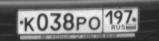

In [9]:
from scipy.special import softmax

def fprediction(photo_url):
    image = jpg_to_numpy(photo_url)
        
    #feature = padding_image(image)[:,:, np.newaxis]
    if len(image.shape) == 3:
        image = np.average(image, axis=2)
    feature = image[:,:, np.newaxis]
   
    prediction = next(model.predict(lambda: tf.data.Dataset.from_tensors(np.array([feature])) ))
    regno = ''
    for t in prediction['prediction'].argmax(axis=1):
        regno += token_dict_decode[t]
        
    photo = Image.open(photo_url)
    print(regno)
    print('scor:')
    print('[', end='')
    for scor in softmax(prediction['prediction'], axis=1).max(axis=1):
        print(scor, end=', ')
    print(']')
    return photo

fprediction('test.out/10002465555101_К038РО197.jpg')

In [10]:
fprediction('test.out/160002169085324_М707УХ177.jpg')

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from pro/model.ckpt-19000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
М707УХ177
scor:
[0.9542531, 0.6529092, 0.7864285, 0.9998131, 0.99552774, 0.99998665, 0.98356926, 0.995579, 0.9784517, ]


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from pro/model.ckpt-19000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
М528ВС777
scor:
[0.99998474, 0.9928616, 1.0, 0.99158037, 0.9999962, 0.99999046, 1.0, 0.99996185, 0.8383408, ]


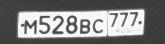

In [39]:
fprediction('test.out/60002109049881_М528ВС777.jpg')

In [19]:

from scipy.special import softmax

In [36]:
print('[', end='')
for scor in softmax(prediction['prediction'], axis=1).max(axis=1):
    print(scor, end=', ')
print(']')

[1.0, 0.8925811, 0.9878182, 0.9999466, 0.77878296, 0.99996185, 1.0, 0.99862385, 0.8230029, ]


In [28]:
import math as m

In [30]:
(m.exp(12) + m.exp(31)) / (m.exp(43))

6.1442123877529815e-06